In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize Spark session
spark = SparkSession.builder \
    .appName("BreweryDataAnalysis") \
    .getOrCreate()

In [3]:
#Loading Data
path = 'F:/Studies/Georgian/BDAT1002/G14/brewery_data_complete_extended.csv'
filetype = 'csv'

options = {
    "header": "true",
    "inferSchema": "true",
    "delimiter": ","
}

# Load the data into a Spark DataFrame with specified options
df = spark.read.format(filetype).options(**options).load(path)

# Show the first few rows of the DataFrame
df.show()

+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+
|Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+-------

In [3]:
#SUmmary Statistics 
df.describe().show()

+-------+------------------+----------+--------+---------------+-----------------+------------------+-------------------+--------------------+-------------------+------------------+-----------------+----------------+-----------------+------------------+------------------+--------------------+-------------------+------------------------+----------------------------+
|summary|          Batch_ID|Beer_Style|     SKU|       Location|Fermentation_Time|       Temperature|           pH_Level|             Gravity|    Alcohol_Content|        Bitterness|            Color|Ingredient_Ratio|  Volume_Produced|       Total_Sales|     Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+-------+------------------+----------+--------+---------------+-----------------+------------------+-------------------+--------------------+-------------------+------------------+-----------------+----------------+-----------------+------------------+-----------

In [4]:
#Total Row Counting

total_rows = df.count()
print(f"Total Rows: {total_rows}")

Total Rows: 10000000


In [6]:

# Analyze correlation between fermentation time and quality score for each beer style
correlation_per_style = df.groupby("Beer_Style").agg(F.corr("Fermentation_Time", "Quality_Score").alias("Correlation"))
correlation_per_style.show()

# Analyze impact of time on other metrics
metrics_impact = df.groupby("Fermentation_Time").agg(
    F.mean("Quality_Score").alias("Mean_Quality_Score"),
    F.mean("Alcohol_Content").alias("Mean_Alcohol_Content"),
    F.mean("Loss_During_Fermentation").alias("Mean_Loss_During_Fermentation")
)
metrics_impact.show()

#Calculate correlation between fermentation time and quality score directly
correlation_direct = df.corr("Fermentation_Time", "Quality_Score")
print(f"Correlation between Fermentation Time and Quality Score: {correlation_direct}")

+----------+--------------------+
|Beer_Style|         Correlation|
+----------+--------------------+
|    Porter|-6.32259701654252...|
|      Sour|3.507579268076007...|
|     Lager|0.001109483041069...|
|Wheat Beer|0.001328033628765...|
|   Pilsner|-6.32043366157912...|
|       Ale|7.058526516012365E-5|
|     Stout|-9.35919444271942...|
|       IPA|-9.87582425653007...|
+----------+--------------------+

+-----------------+------------------+--------------------+-----------------------------+
|Fermentation_Time|Mean_Quality_Score|Mean_Alcohol_Content|Mean_Loss_During_Fermentation|
+-----------------+------------------+--------------------+-----------------------------+
|               12| 8.000093315691762|   5.248921862771727|           2.9984511317000067|
|               13| 8.000176426863147|   5.249685273377983|            3.002007721289939|
|               16|  8.00036851007097|   5.249921887693433|            3.000051890338007|
|               19| 8.000331750796109|   5.25000001

In [19]:
# Show the first few rows of the DataFrame
df.show()

# Distribution of losses across batches and styles
loss_stats = df.groupby("Beer_Style").agg(
    F.mean("Loss_During_Brewing").alias("Mean_Brewing_Loss"),
    F.stddev("Loss_During_Brewing").alias("Stddev_Brewing_Loss"),
    F.mean("Loss_During_Fermentation").alias("Mean_Fermentation_Loss"),
    F.stddev("Loss_During_Fermentation").alias("Stddev_Fermentation_Loss")
)
loss_stats.show()

# Identify batches with high losses
brewing_loss_threshold = df.stat.approxQuantile("Loss_During_Brewing", [0.95], 0.01)[0]
fermentation_loss_threshold = df.stat.approxQuantile("Loss_During_Fermentation", [0.95], 0.01)[0]

high_loss_brewing = df.filter(df["Loss_During_Brewing"] > brewing_loss_threshold)
high_loss_fermentation = df.filter(df["Loss_During_Fermentation"] > fermentation_loss_threshold)

# Investigate causes of high losses
high_loss_brewing.join(df, on="Batch_ID").show()
high_loss_fermentation.join(df, on="Batch_ID").show()

+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+
|Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+-------

##Visualisation 

In [6]:
# Importing More libraries for Visualization and Analysis (Includes Pandas and matplotlib)
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

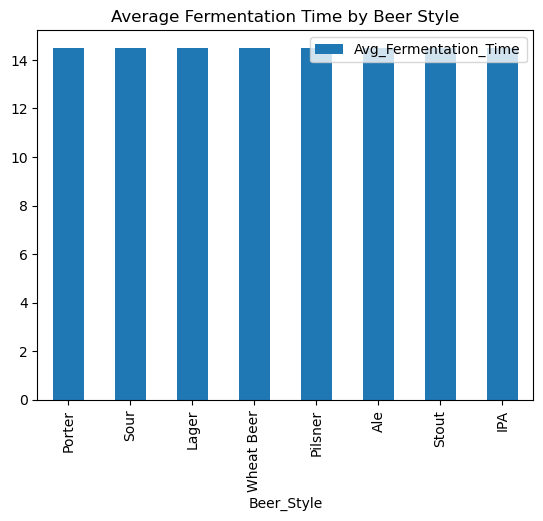

In [5]:
# Visualize average fermentation time by beer style
fermentation_time_avg = df.groupby("Beer_Style").agg(F.mean("Fermentation_Time").alias("Avg_Fermentation_Time")).toPandas()
fermentation_time_avg.plot(kind="bar", x="Beer_Style", y="Avg_Fermentation_Time", title="Average Fermentation Time by Beer Style")
plt.show()

In [ ]:
# Data Transformations

In [23]:
#Create a new column representing the ratio of Total_Sales to Volume_Produced
from pyspark.sql.functions import col

df = df.withColumn("Sales_Per_Liter", col("Total_Sales") / col("Volume_Produced"))
df.show()


+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+-----+-------------------+
|Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|Month|    Sales_Per_Liter|
+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+

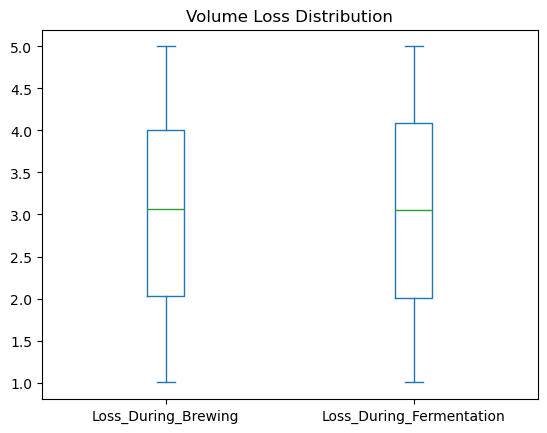

In [14]:
# Sample the first 1000 rows from the DataFrame
sample_df = df.limit(1000)

# Visualize volume loss during brewing and fermentation
loss_data = sample_df.select("Loss_During_Brewing", "Loss_During_Fermentation").toPandas()
loss_data.plot(kind="box", title="Volume Loss Distribution")
plt.show()



In [36]:
top_beer_styles = df.groupBy("Beer_Style").agg({"Total_Sales": "sum"}).orderBy("sum(Total_Sales)", ascending=False).limit(5)
top_beer_styles.show()

+----------+--------------------+
|Beer_Style|    sum(Total_Sales)|
+----------+--------------------+
|       Ale|1.314638271068101...|
|    Porter|1.313051202605402...|
|      Sour|1.312554186649535...|
|   Pilsner|1.312235003270339...|
|     Lager|1.311766538654772...|
+----------+--------------------+



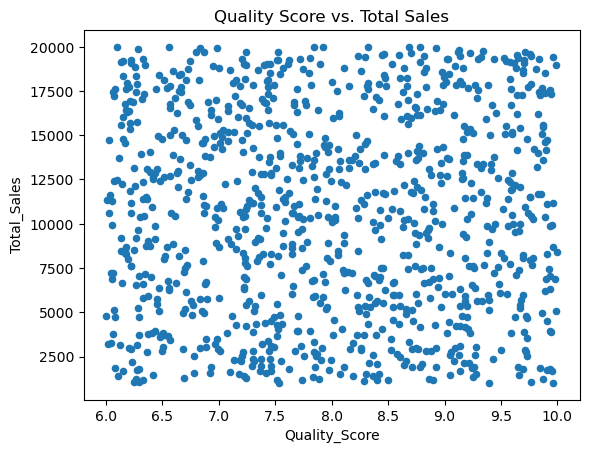

In [15]:
# Visualize the correlation between quality score and total sales
quality_vs_sales = sample_df.select("Quality_Score", "Total_Sales").toPandas()
quality_vs_sales.plot(kind="scatter", x="Quality_Score", y="Total_Sales", title="Quality Score vs. Total Sales")
plt.show()

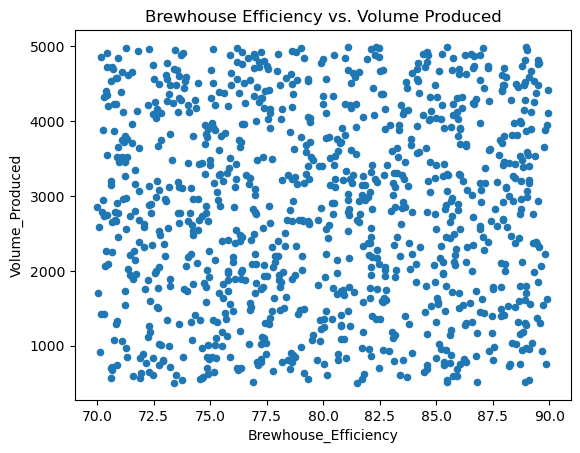

In [16]:
# Visualize the relationship between brewhouse efficiency and total volume produced
brewhouse_vs_volume = sample_df.select("Brewhouse_Efficiency", "Volume_Produced").toPandas()
brewhouse_vs_volume.plot(kind="scatter", x="Brewhouse_Efficiency", y="Volume_Produced", title="Brewhouse Efficiency vs. Volume Produced")
plt.show()

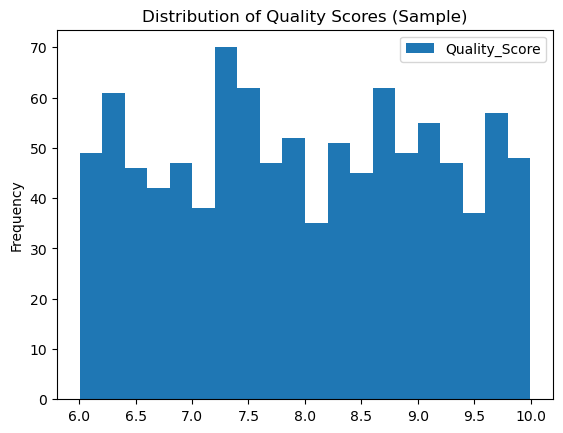

In [17]:
# Distribution of Quality Scores
quality_distribution = sample_df.select("Quality_Score").toPandas()
quality_distribution.plot(kind="hist", bins=20, title="Distribution of Quality Scores (Sample)")
plt.show()


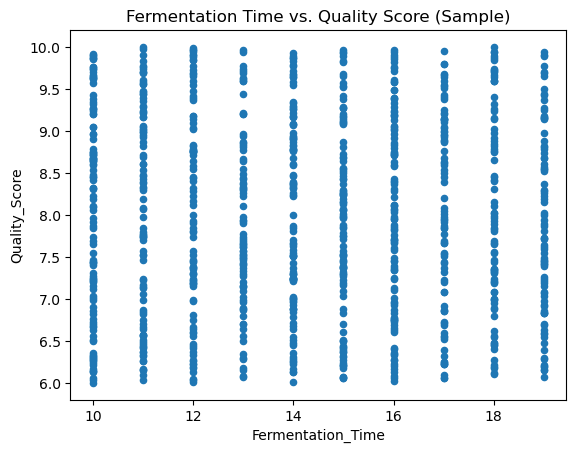

In [18]:
# Relationship between Fermentation Time and Quality Score
fermentation_vs_quality = sample_df.select("Fermentation_Time", "Quality_Score").toPandas()
fermentation_vs_quality.plot(kind="scatter", x="Fermentation_Time", y="Quality_Score", title="Fermentation Time vs. Quality Score (Sample)")
plt.show()

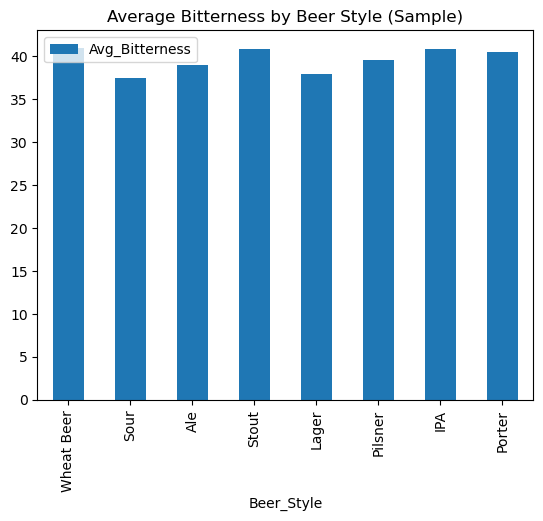

In [19]:
# BItterness distribution
bitterness_by_style = sample_df.groupby("Beer_Style").agg(F.mean("Bitterness").alias("Avg_Bitterness")).toPandas()
bitterness_by_style.plot(kind="bar", x="Beer_Style", y="Avg_Bitterness", title="Average Bitterness by Beer Style (Sample)")
plt.show()


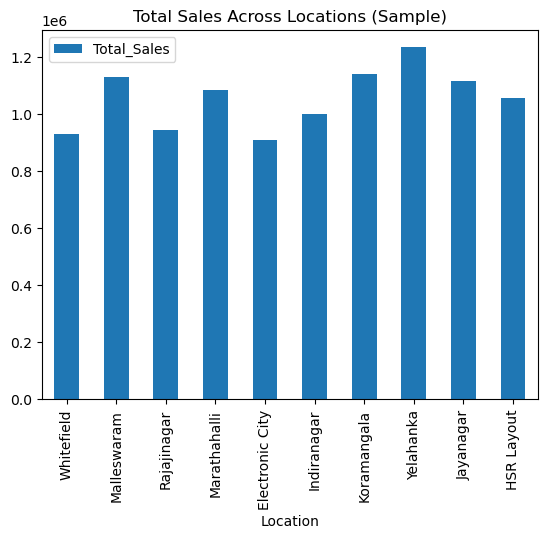

In [20]:
# Sales Performance across different Locations

sales_by_location = sample_df.groupby("Location").agg(F.sum("Total_Sales").alias("Total_Sales")).toPandas()
sales_by_location.plot(kind="bar", x="Location", y="Total_Sales", title="Total Sales Across Locations (Sample)")
plt.show()